In [1]:
import numpy as np
import math
import ceo
from IPython.html.widgets import interact
%pylab inline

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


###An off-axis guide star array and the GMT telescope model

In [20]:
nLenset = 25
nPx= 16*25+1
D = 25.5
N_GS = 5
zen = np.linspace(0,10,N_GS)*ceo.constants.ARCMIN2RAD
azi = zeros(N_GS)
#zen[1:] = np.ones(N_GS-1)*5*60*ceo.constants.ARCSEC2RAD
#azi[1:] = np.arange(N_GS-1)*2*math.pi/(N_GS-1)
src    = ceo.Source("R",zenith=zen,azimuth=azi,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
gmt = ceo.GMT_MX(D,nPx,M1_radial_order=10,M2_radial_order=10)

### Field aberrations

wfe rms: [ 0.    0.33  1.28  2.86  5.1 ] nm


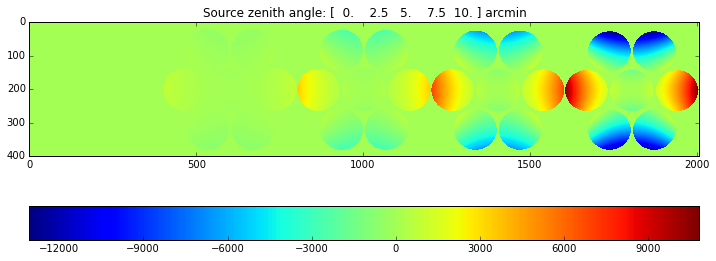

In [58]:
gmt.reset()
src.reset()
gmt.propagate(src)
phi0 = src.phase.host(units='nm')

fig = figure()
fig.set_size_inches((12,6))
imshow(phi0.T,interpolation='None')
colorbar(orientation='horizontal')
src.wavefront.rms()

A = src.amplitude.host(shape=(N_GS,nPx,nPx)).sum(axis=0)
mask0 = A==N_GS
title("Source zenith angle: "+array_str(src.zenith*ceo.constants.RAD2ARCMIN)+" arcmin")
print "wfe rms: "+np.array_str(src.wavefront.rms(-6),precision=2,suppress_small=True)+" nm"

In [59]:
def field_gradient(T=[0,0,0],R=[0,0,0],T1=[0,0,0],R1=[0,0,0]):
    gmt.reset()
    #gmt.M1.update(origin=[0,0,0],euler_angles=[0,100e-3*math.pi/180/3600,0],idx=1)
    for k in range(1,7):
        gmt.M1.update(origin=T1,euler_angles=R1,idx=k)
        gmt.M2.update(origin=T,euler_angles=R,idx=k)
    #gmt.M2.update(origin=[0,0*10e-6,0],euler_angles=[50e-3*math.pi/180/3600,0,0],idx=1)
    src.reset()
    gmt.propagate(src)
    phi = src.phase.host(units='nm')

    A = src.amplitude.host(shape=(N_GS,nPx,nPx)).sum(axis=0)
    mask = np.logical_and(A==N_GS,mask0)

    phi_e = (phi-phi0)

    nSample = N_GS-1
    buff = np.reshape(phi_e,(N_GS,nPx,nPx))*mask
    phi_e_diff = (buff[1:,:,:] - buff[0,:,:])
        
    P = src.rays.piston_mask
    phi_e_diff_prm = np.zeros((nSample,nPx,nPx))
    for kSample in range(nSample):
        Q = src.rays.piston_mask[kSample+1]*mask.reshape(1,-1)#src.wavefront.amplitude.host()[kSample+1,:]
        ps = phi_e_diff[kSample,:,:].reshape(-1,1)
        p = np.dot(Q,ps)/np.sum(Q,axis=1).reshape(-1,1)
        phi_e_diff_prm[kSample,:,:] = np.reshape(np.dot(Q.T,p),(nPx,nPx))
    phi_e_diff_prm = (phi_e_diff - phi_e_diff_prm)
    
    phi_e = np.reshape( buff, (N_GS*nPx,nPx))
    fig,(ax1,ax2,ax3) = subplots(nrows=3)
    fig.set_size_inches((12,10))
    h1 = ax1.imshow(phi_e.T,interpolation='None')
    hc = colorbar(h1,ax=ax1,orientation='horizontal')
    src.wavefront.rms()*1e9

    h2 = ax2.imshow(phi_e_diff.reshape((nSample*nPx,nPx)).T,interpolation='None')
    colorbar(h2,ax=ax2,orientation='horizontal')
    
    h3 = ax3.imshow(phi_e_diff_prm.reshape((nSample*nPx,nPx)).T,interpolation='None')
    colorbar(h3,ax=ax3,orientation='horizontal')

### x-axis translation

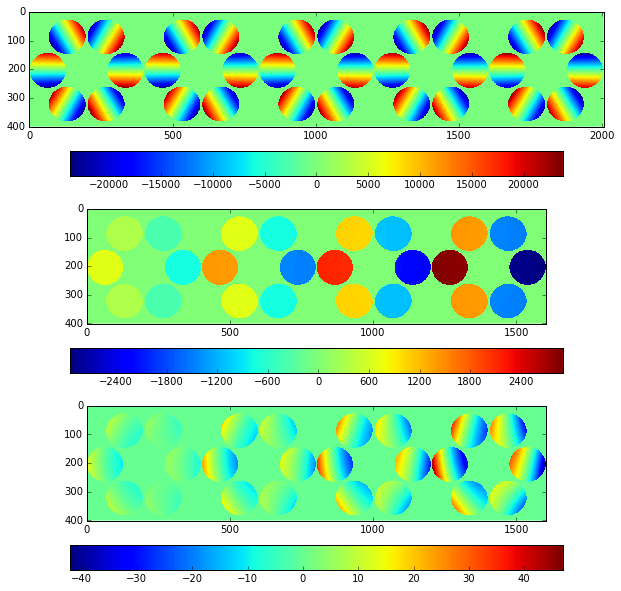

In [60]:
field_gradient(T=[100e-6,0,0])

### y-axis translation

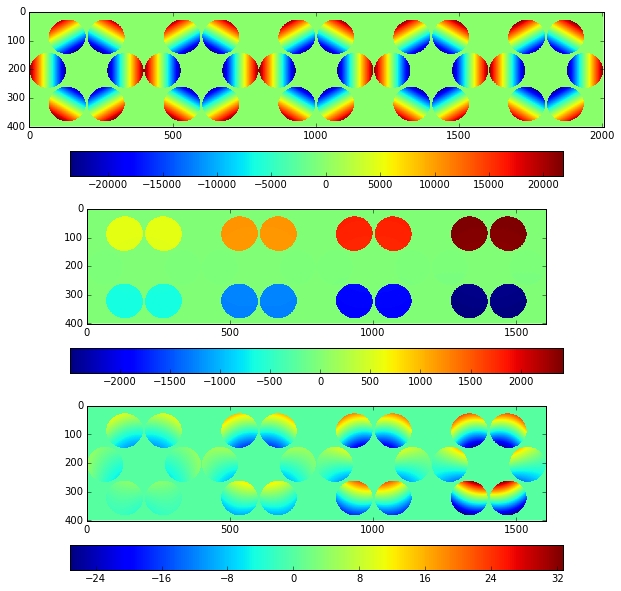

In [61]:
field_gradient(T=[0,100e-6,0])

### z-axis translation

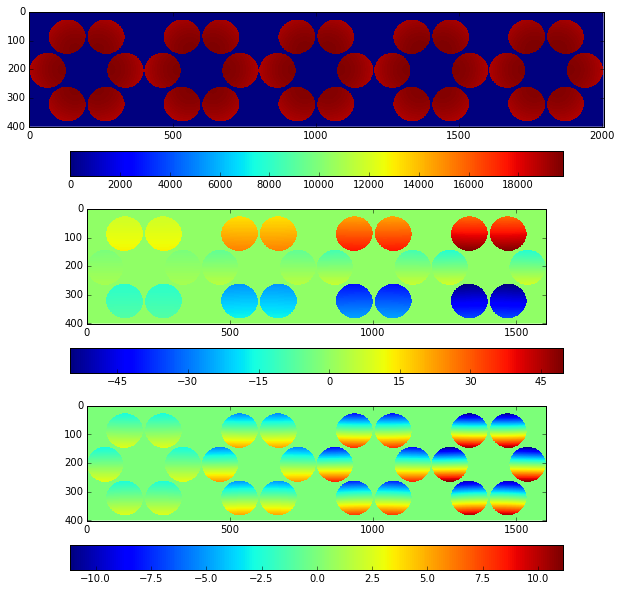

In [39]:
field_gradient(T=[0,0,10e-6])

### x-axis rotation

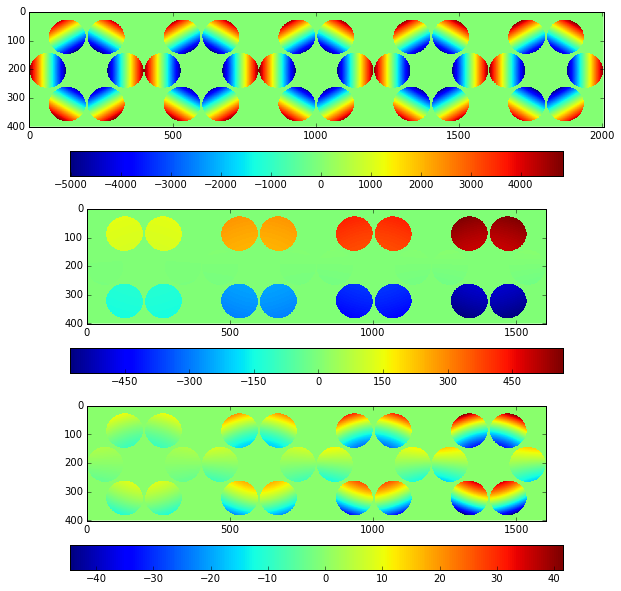

In [40]:
field_gradient(R=[1*math.pi/180/3600,0,0])

### y-axis rotation

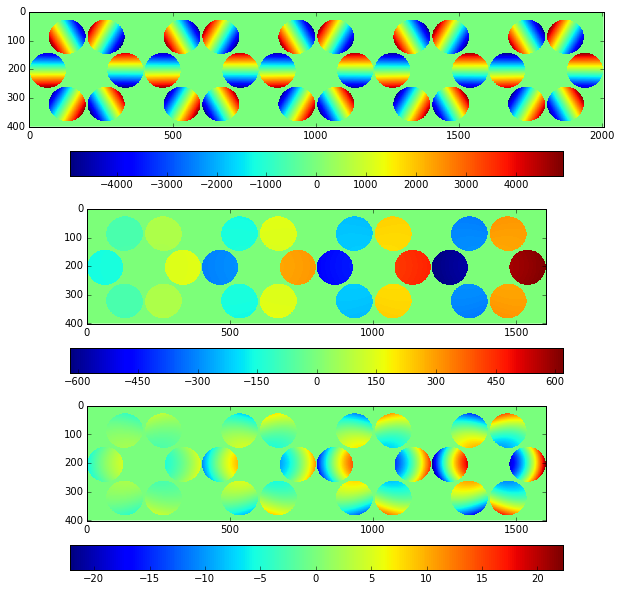

In [46]:
field_gradient(R=[0,1*math.pi/180/3600,0])

### z-axis rotation

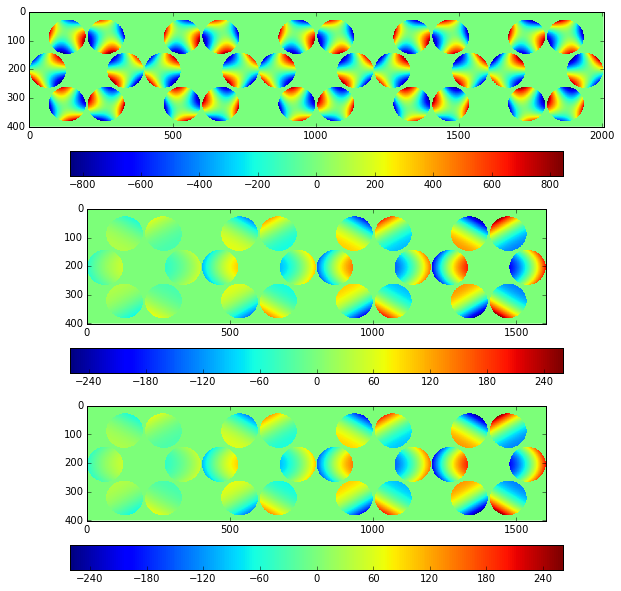

In [42]:
field_gradient(R=[0,0,1*ceo.constants.ARCMIN2RAD])

### x-axis translation compensated with y-axis rotation

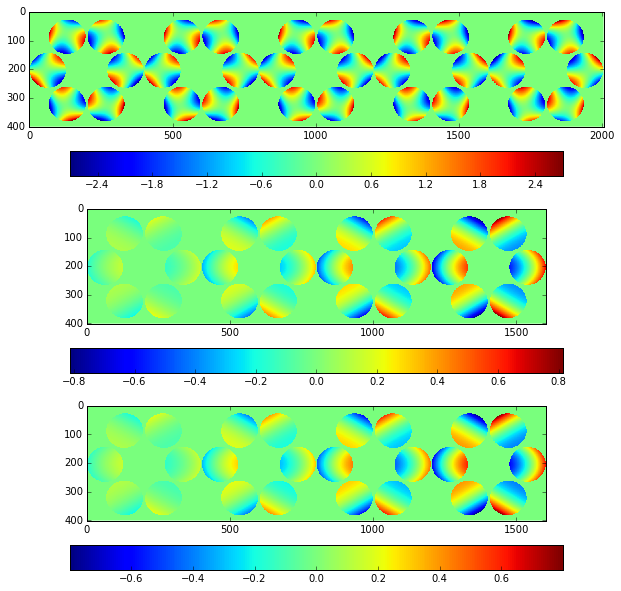

In [44]:
def fun(x_micron=1.0):
    field_gradient(T=[1e-6*x_micron,0,0],R=[0,x_micron*4.820e-2*ceo.constants.ARCSEC2RAD,0])
itrt1 = interact(fun,x_micron=(-1000,1000))

### y-axis translation compensated with x-axis rotation

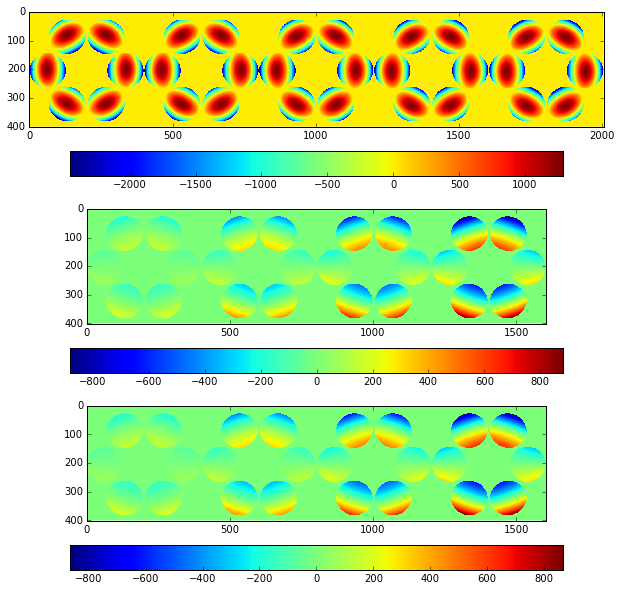

In [45]:
def fun(y_micron=1):
    field_gradient(T=[0,1e-6*y_micron,0],R=[-46*ceo.constants.MAS2RAD*y_micron,0,0])
itrt2 = interact(fun,y_micron=(-1000,1000))

### M1 x-axis rotation compensated with M2 x-axis rotation

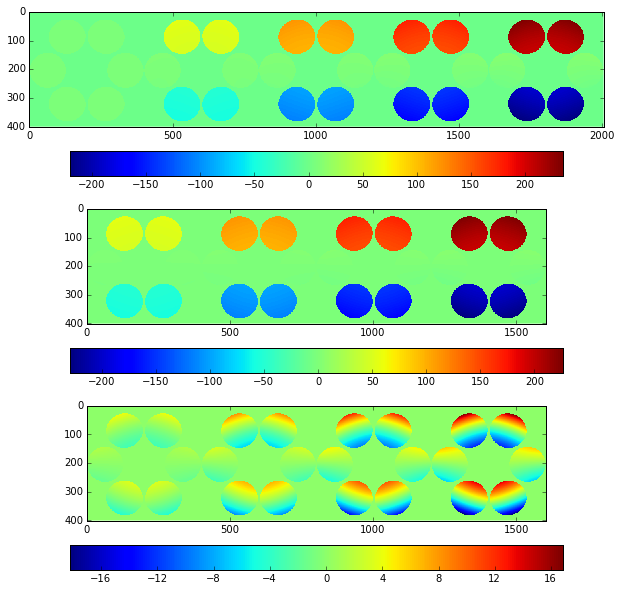

In [47]:
mas2rad = 1e-3*math.pi/180/3600
field_gradient(R1=[50*mas2rad,0,0],R=[399.3*mas2rad,0,0])

### M1 y-axis rotation compensated with M2 y-axis rotation

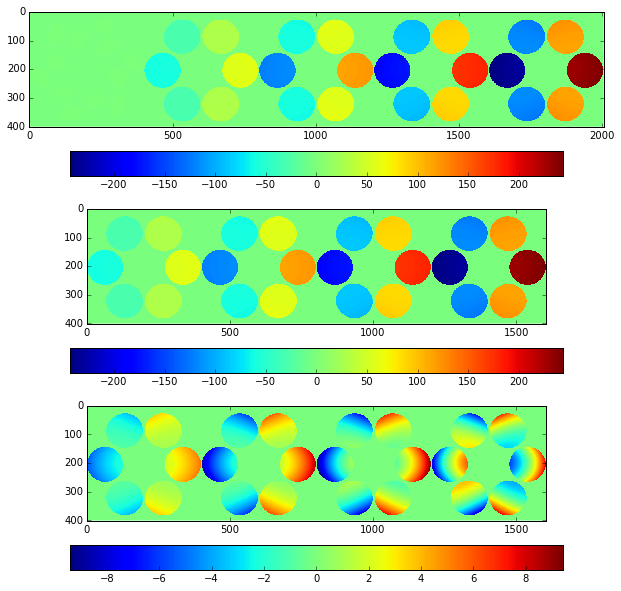

In [14]:
mas2rad = 1e-3*math.pi/180/3600
field_gradient(R1=[0,50*mas2rad,0],R=[0,397.7*mas2rad,0])

### M1 global tip-tilt compensated with M2  global tip-tilt 

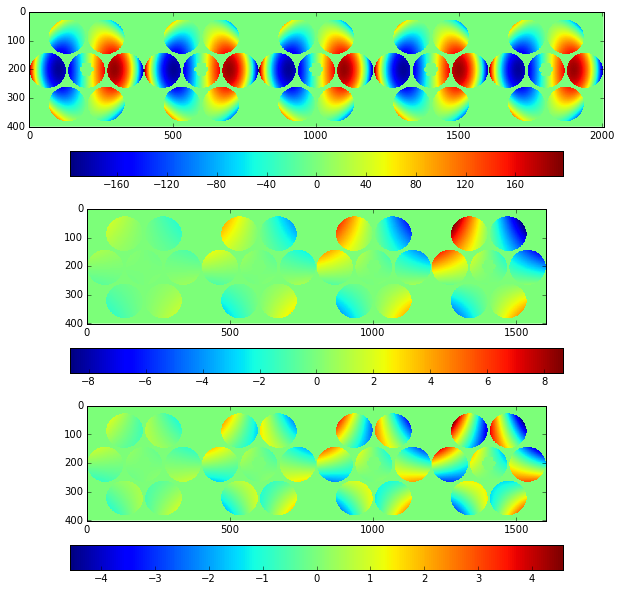

In [15]:
def field_gradient_global(tip1=0,tilt1=0,tip2=0,tilt2=0):
    gmt.reset()
    gmt.M1.global_tiptilt(tip1,tilt1)
    gmt.M2.global_tiptilt(tip2,tilt2)
    src.reset()
    gmt.propagate(src)
    phi = src.phase.host(units='nm')

    A = src.amplitude.host(shape=(N_GS,nPx,nPx)).sum(axis=0)
    mask = np.logical_and(A==N_GS,mask0)

    phi_e = (phi-phi0)

    nSample = N_GS-1
    buff = np.reshape(phi_e,(N_GS,nPx,nPx))*mask
    phi_e_diff = (buff[1:,:,:] - buff[0,:,:])
        
    P = src.rays.piston_mask
    phi_e_diff_prm = np.zeros((nSample,nPx,nPx))
    for kSample in range(nSample):
        Q = src.rays.piston_mask[kSample+1]*src.wavefront.amplitude.host()[kSample+1,:]
        ps = phi_e_diff[kSample,:,:].reshape(-1,1)
        p = np.dot(Q,ps)/np.sum(Q,axis=1).reshape(-1,1)
        phi_e_diff_prm[kSample,:,:] = np.reshape(np.dot(Q.T,p),(nPx,nPx))
    phi_e_diff_prm = mask*(phi_e_diff - phi_e_diff_prm)
    
    phi_e = np.reshape( buff, (N_GS*nPx,nPx))
    fig,(ax1,ax2,ax3) = subplots(nrows=3)
    fig.set_size_inches((12,10))
    h1 = ax1.imshow(phi_e.T,interpolation='None')
    colorbar(h1,ax=ax1,orientation='horizontal')
    src.wavefront.rms()*1e9

    h2 = ax2.imshow(phi_e_diff.reshape((nSample*nPx,nPx)).T,interpolation='None')
    colorbar(h2,ax=ax2,orientation='horizontal')
    
    h3 = ax3.imshow(phi_e_diff_prm.reshape((nSample*nPx,nPx)).T,interpolation='None')
    colorbar(h3,ax=ax3,orientation='horizontal')
field_gradient_global(tip1=100*ceo.constants.MAS2RAD,tilt1=0,tip2=215.7*ceo.constants.MAS2RAD,tilt2=0)

## Shack-Hartmann sensitivity

In [16]:
gs = ceo.Source('R',rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
wfs = ceo.ShackHartmann(nLenset,16,D/nLenset)
gmt.reset()
gmt.propagate(gs)
wfs.calibrate(gs,0.8)

### Piston

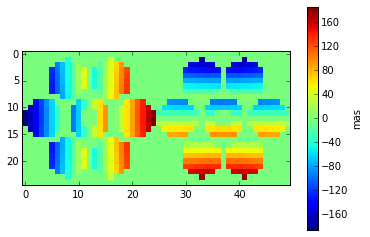

In [20]:
def piston_fun(piston_micron=1):
    gmt.reset()
    for k in range(1,8):
        gmt.M2.update(origin=[0,0,piston_micron*1e-6],idx=k)
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
    imshow(wfs.c.host(shape=(2*nLenset,nLenset),units='mas').T,interpolation='none')
    hc = colorbar()
    hc.set_label('mas')
piston_itrt = interact(piston_fun,piston_micron=(-100,100))

### x-axis translation compensated with y-axis rotation

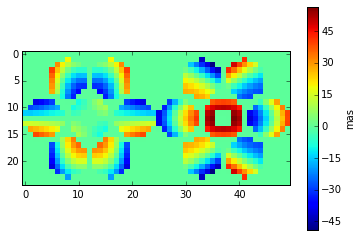

In [18]:
def xy_fun(x_micron=1):
    gmt.reset()
    for k in range(1,8):
        gmt.M2.update(origin=[1e-6*x_micron,0,0],euler_angles=[0,x_micron*4.820e-2*ceo.constants.ARCSEC2RAD,0],idx=k)
    gs.reset()
    gmt.propagate(gs)
    wfs.analyze(gs)
    wfs.reset()
    imshow(wfs.c.host(shape=(2*nLenset,nLenset),units='mas').T,interpolation='none')
    hc = colorbar()
    hc.set_label('mas')
xy_itrt =interact(xy_fun,x_micron=(-1000,1000))

In [19]:
wfs.pixel_scale_arcsec*1e3

64.71053108000768